# Modeling

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Dataset loading and exploration](#Dataset-loading-and-preparation)
2. [Multi-class Classifiers](#Multi-class-Classifiers)
3. [Neural Networks Adaptation](#Neural-Networks-Adaptation)

## Dataset loading and preparation

In [19]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [20]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
%matplotlib inline
sns.set_theme()

In [21]:
df = pd.read_csv('noun_phrases_class.csv')
df['type'].value_counts()

not_skill     3459
hard_skill     468
soft_skill      73
Name: type, dtype: int64

In [22]:
df['type'].isnull().sum()

0

<AxesSubplot: >

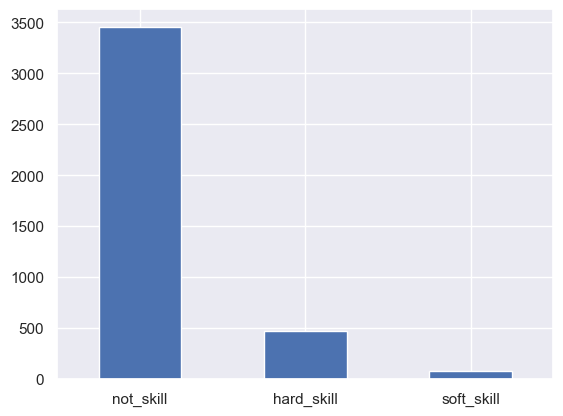

In [23]:
df['type'].value_counts().plot(kind='bar', rot=0)

In [24]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

transformer = TfidfVectorizer(stop_words = 'english')
X = transformer.fit_transform(df["phrase"])
np.shape(X)

(4000, 2760)

In [25]:
from sklearn.model_selection import train_test_split

# Extract features and prediction vectors
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_train.shape, X_test.shape

((2800, 2760), (1200, 2760))

## Multi-class Classifiers

For this part I am going to train various classifiers and compare the training results. In detail the classifiers I will use are:

1. Multinomial Naive Bayes
2. Support Vector Machine
3. Random Forest
4. Logistic Regression

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

models = [
    MultinomialNB(),
    LinearSVC(),
    RandomForestClassifier(),
    LogisticRegression()
]

In [27]:
measurements = []

for model in models:
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test  = model.score(X_test,  y_test)
    
    measurements.append([model.__class__.__name__, score_train, score_test])

In [28]:
results = pd.DataFrame(measurements, columns=['model', 'train_accuracy', 'test_accuracy'])
results

,model,train_accuracy,test_accuracy
0,MultinomialNB,0.894643,0.897500
1,LinearSVC,0.976786,0.925000
2,RandomForestClassifier,0.997857,0.914167
3,LogisticRegression,0.923214,0.905833


In [29]:
# Null Accuracy

null_accuracy = (1049/(1049+131+20))

print('Null accuracy score: {0:0.4f}\n'.format(null_accuracy))

print(f'{y_test.value_counts()}\n')

Null accuracy score: 0.8742

0    1049
1     131
2      20
Name: type, dtype: int64



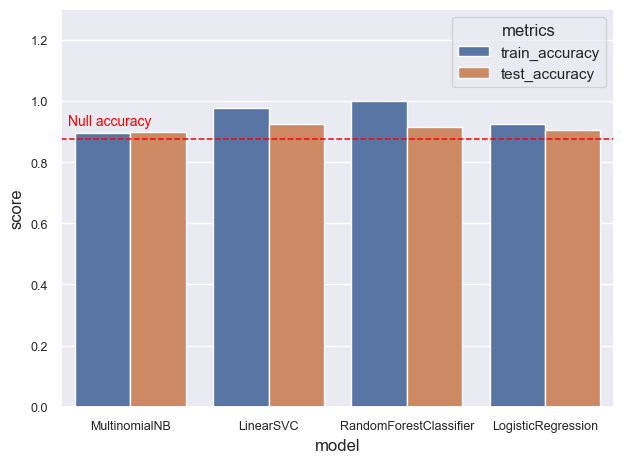

In [30]:
metrics_plt = sns.barplot(data=results.melt(id_vars='model', value_name='score', var_name='metrics'),
                          x='model', y='score', hue='metrics')
metrics_plt.tick_params(labelsize=9)

plt.axhline(y=null_accuracy, ls='--', c='red', linewidth=1.1)
plt.text(-0.45, 0.92, "Null accuracy", c='red', size='small')
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()

As we can see 3 models perform over the null accuracy score, which is the ideal. It seems like the Random Forest classifier has learned to almost choose the most common class over each prediction. Let's reinforce those results by implementing cross validation to our models.

In [31]:
from sklearn.model_selection import cross_val_score

# Get cross validated scores for input models
def get_cross_val_scores(models, x, y, cv=10):
    measurements = []
    for model in models:
        accuracies = cross_val_score(model, x, y, cv = cv, scoring = 'accuracy')

        for i, accuracy in enumerate(accuracies):
            measurements.append((model.__class__.__name__, i, accuracy))

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'accuracy_score'])
    return results

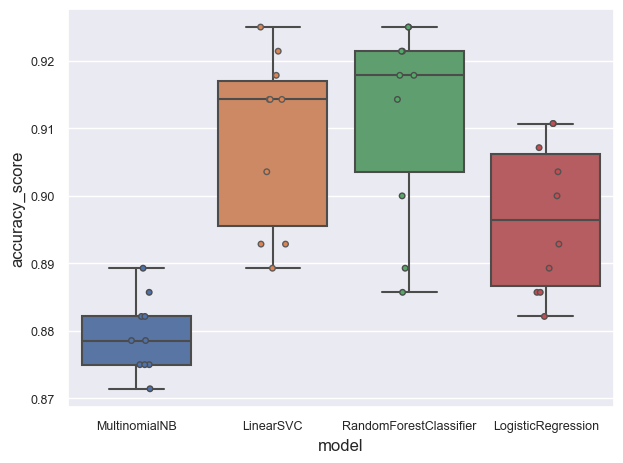

In [32]:
cv_results = get_cross_val_scores(models, X_train, y_train)

cs_metrics_bxplt = sns.boxplot(x='model', y='accuracy_score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='accuracy_score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [33]:
cv_results.groupby('model').accuracy_score.mean()

model
LinearSVC                 0.908571
LogisticRegression        0.896786
MultinomialNB             0.879286
RandomForestClassifier    0.911786
Name: accuracy_score, dtype: float64

As we can see the linear SVC model performed the best, with the best accuracy score of all models. On the other hand the worst performing model is the random forest classifier, with even worse score than the null accuracy indication.

In [16]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter configurations for GridSearch
params_mnb = {'alpha': np.arange(0.01, 1, 0.01)}

params_svc = {'random_state': [0], 'C': np.arange(0.01, 1, 0.01), 'multi_class': ['ovr', 'crammer_singer']}

params_rfc = {'random_state': [0], 'n_jobs': [-1], 'n_estimators': [25,50,100,200], 'max_features': ['sqrt',None],
              'min_samples_leaf': [2,4,], 'min_samples_split': [2,6,], 'oob_score': [True,False], 'criterion': ['gini'],
              'warm_start': [True,False], 'max_depth': [None, 3, 5]}

params_lrc = {'random_state': [0], 'n_jobs': [-1], 'C': np.arange(0.01, 1, 0.01), 'warm_start': [True,False],
              'multi_class': ['multinomial']}
    
# Automatic hyperparameter tuning using GridSearch
mnb_gs = GridSearchCV(models[0], params_mnb, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
svc_gs = GridSearchCV(models[1], params_svc, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
rfc_gs = GridSearchCV(models[2], params_rfc, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
lrc_gs = GridSearchCV(models[3], params_lrc, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)

models_gs = [
    mnb_gs,
    svc_gs,
    rfc_gs,
    lrc_gs
]

# Try to fit the models using the Grid Search
for model in models_gs:
    model.fit(X, y)
    print(model.__class__.__name__)
    
#mnb_gs.fit(X, y)
#lrc_gs.fit(X, y)
#rfc_gs.fit(X, y)
#svc_gs.fit(X, y)
                  
print(mnb_gs.best_params_)
print(lrc_gs.best_params_)
print(rfc_gs.best_params_)
print(svc_gs.best_params_)

{'alpha': 0.05}
{'C': 0.99, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 0, 'warm_start': True}
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'warm_start': True}
{'C': 0.8300000000000001, 'multi_class': 'crammer_singer', 'random_state': 0}


D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [35]:
# Update the models to use the newly found hyperparameters

models = [
    MultinomialNB(**mnb_gs.best_params_),
    LinearSVC(**svc_gs.best_params_),
    RandomForestClassifier(**rfc_gs.best_params_),
    LogisticRegression(**lrc_gs.best_params_)
]

D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Distributions\Miniconda3\envs\science\lib\site-packages\s

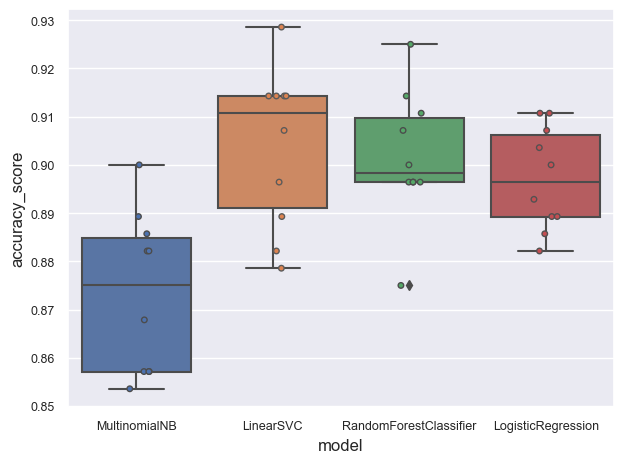

In [36]:
cv_results = get_cross_val_scores(models, X_train, y_train)

cs_metrics_bxplt = sns.boxplot(x='model', y='accuracy_score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='accuracy_score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate and return metrics
def get_performance_metrics(tp, tn, fp, fn):
    accuracy    = (tp + tn) / float(tp + tn + fp + fn)
    error       = (fp + fn) / float(tp + tn + fp + fn)
    precision   = tp / float(tp + fp)
    recall      = tp / float(tp + fn)
    specificity = tn / float(tn + fp)
    f1          = 2 * (precision * recall) / (precision + recall)

In [ ]:
# NEW PREDICTION

new_phrase = {
    'phrase': ["mediocre skills of R"],
    'type': [None]
}

new = pd.concat([df, pd.DataFrame(new_phrase)], axis=0).reset_index(drop=True)
print(new['phrase'].iloc[-1], '\n')

X = transformer.transform(new["phrase"])
print('TfIdf:\n', X[-1], '\n')

yy = models[1].predict(X[-1])
print(f'Class: {yy}')